# Random forest model

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

import pickle

plt.style.use("default")

In [77]:
# read our fresh preprocessed data from previous notebook

data = pd.read_csv("preprocessed_features.csv",index_col="Unnamed: 0")

In [78]:
X = data.drop("classes", axis = 1)
y = data.classes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [79]:
# Make a decision tree
tree = RandomForestClassifier()

# Pass X_train as training data to the model
tree.fit(X_train, y_train);

//anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


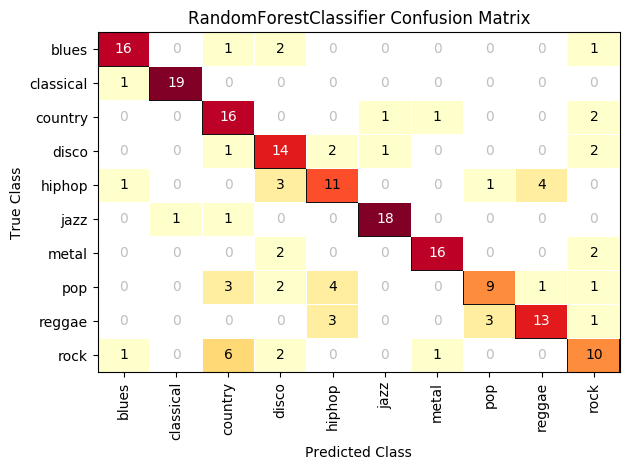

In [80]:
# See the results of the model with standard parameters in a confusion matrix
tree_cm = ConfusionMatrix(tree)
tree_cm.score(X_test,y_test)
tree_cm.show()

//anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


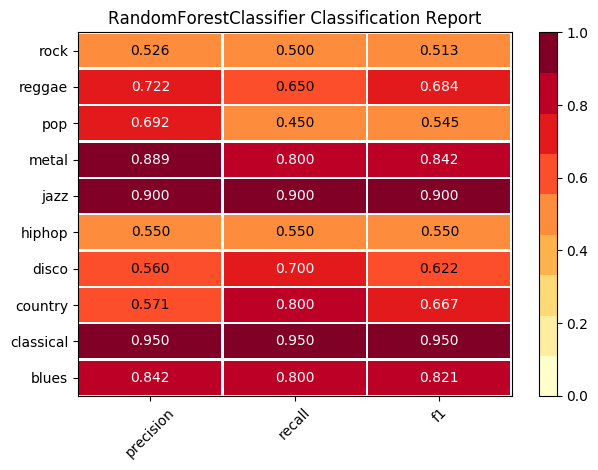

In [81]:
# And in a classification report

tree_report = ClassificationReport(tree)
tree_report.score(X_test,y_test)
tree_report.show();

# Hyperparameters tuning
How to optimize random forest model.
SkiKit Learn has _default parameters_ for all models but they are not garanteed to be optimal for our problem.
It is hard to know before which parameters will work best -> **trial-and-error method.**

We want the best model possible without **overfitting** = a model that would not be able to generalized new data). Performs + on training set but - on test set.

We will create a random **hyperparameter grid** that will be used to try the random forest model with various parameters.
Then we can choose the one that performs best.


In [74]:
# Check parameters in use in random forest: uncomment to see
# tree = tree = RandomForestClassifier()
print('Parameters currently in use:\n')
print(tree.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## Grid search and random grid search
**Grid search** is great for spot-checking combinations that are known to perform well generally, or when one wants to try all possibilities. 
**Random search** is great for discovery and getting hyperparameter combinations that you would not have guessed intuitively, although it might requires more time to execute (this will depend on the number of iterations)

*I don't know what I am doing with hyperparameters, so I will chosse random.*

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid with multiple values for each parameter
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### On each iteration the algorithm will chosse a different combination of features:
**total 4320 possibilities.**
But it is too much, we only want a few samples.

We use the n_iter parameter to define the num of different compbinations to try  
We use cv parameter to define the number of folds  
More iterations = wider search   
More cv folds = reduce chance of overfitting  
Both **increase** time.

more info [here](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

In [55]:
# Use the random grid to search for best hyperparameters: it takes a long time (15min)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# RandomizedSearchCV requires 2 arg: the model we want to optimize and a dict of values
# Can also have cv (number of fold), n_iter (num of tries) and more.
search = RandomizedSearchCV(estimator = tree, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
result = search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   32.7s finished


In [56]:
# View the best parameters:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6950428505721232
Best Hyperparameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}


In [67]:
# Check results
cv_results = pd.DataFrame(result.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.444388,0.018436,0.057036,0.002581,200,10,2,sqrt,50,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.689139,0.644195,0.695489,0.676274,0.022831,5
1,5.616965,0.102079,0.164827,0.015977,600,10,4,sqrt,90,False,"{'n_estimators': 600, 'min_samples_split': 10,...",0.700375,0.651685,0.721805,0.691288,0.029338,3
2,6.570699,0.405146,0.214167,0.045031,600,2,2,auto,60,False,"{'n_estimators': 600, 'min_samples_split': 2, ...",0.704120,0.651685,0.729323,0.695043,0.032339,1
3,12.449721,0.224311,0.372306,0.008167,1400,5,1,sqrt,30,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.681648,0.651685,0.740602,0.691312,0.036937,2
4,9.166503,1.005050,0.186038,0.057237,1000,10,1,auto,80,False,"{'n_estimators': 1000, 'min_samples_split': 10...",0.704120,0.647940,0.718045,0.690035,0.030304,4


### The important col in *mean_test_score*.  
We can see that there isn't much difference between the different tests and they all are betweeen **0.67** and **0.69**. 

//anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


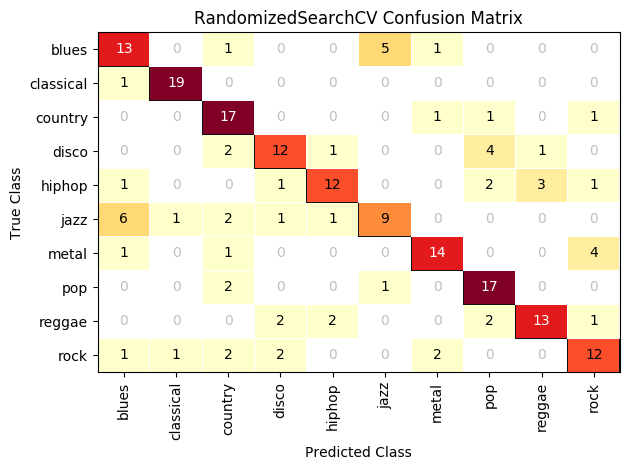

In [70]:
tree_search_cm = ConfusionMatrix(search)
tree_search_cm.score(X_test, y_test)
tree_search_cm.show();

//anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


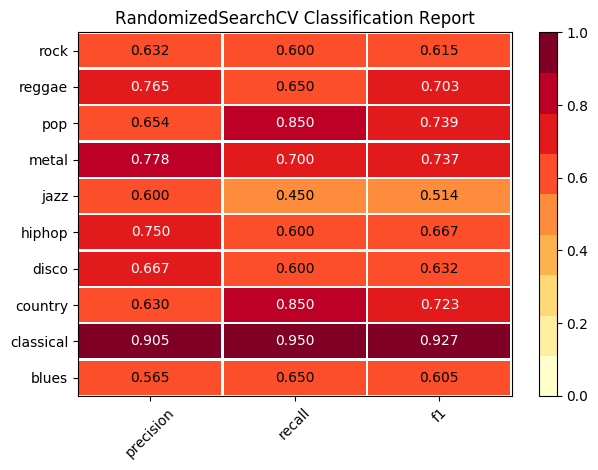

In [71]:
tree_report = ClassificationReport(search)
tree_report.score(X_test,y_test)
tree_report.show();

## Which one should we choose ?
More on metrics:[https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)  
We can use accuracy_score to determine which one is more accurate.  
**Accuracy** is the number of correctly predicted data points out of all data points. 

In [91]:

tree_y_pred = tree.predict(X_test)
search_y_pred = search.predict(X_test)
tree_acc_score = accuracy_score(y_test, tree_y_pred)
search_acc_score = accuracy_score(y_test, search_y_pred)
print('Accuracy score for the Random Tree model with default parameters:')
print(tree_acc_score)
print('Accuracy score for the Random Tree model with custom parameters:')
print(search_acc_score)


Accuracy score for the Random Tree model with default parameters:
0.71
Accuracy score for the Random Tree model with custom parameters:
0.915


We can also check Logistic Loss.  
**Logistic loss** is a measure of confidence of the prediction.  
A lower log_loss value means better predictions...

In [100]:
from sklearn import model_selection

tree_log_loss = model_selection.cross_val_score(tree, X_test, y_test, cv=3, scoring='neg_log_loss')
print('Log_loss for tree model:')
print("Logloss: %.3f (%.3f)" % (tree_log_loss.mean(), tree_log_loss.std()))

search_log_loss = model_selection.cross_val_score(search, X_test, y_test, cv=3, scoring='neg_log_loss')
print('Log_loss for search model:')
print("Logloss: %.3f (%.3f)" % (search_log_loss.mean(), search_log_loss.std()))

Log_loss for tree model:
Logloss: -1.425 (0.062)
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   46.0s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.5s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   32.3s finished


Log_loss for search model:
Logloss: -1.431 (0.039)


In [96]:
# Save model to pickle
pickle.dump(tree, open("model_test_tree.sav","wb"))